In [33]:
import sys ; sys.path.append('../')
from lnos.observer.lueneberger import LuenebergerObserver
from lnos.datasets.exampleSystems import getAutonomousSystem
import lnos.net.linear as ln
from lnos.datasets.plot import plotLogError2D, plotTrajectory2D, plotSimulation2D

import torch
import numpy as np

In [6]:
# Get plant dynamics
f, h, g, u, dim_x, dim_y, eigen = getAutonomousSystem()

# Initiate observer with system dimensions
observer = LuenebergerObserver(dim_x, dim_y, f, g, h, u)

# Set system dynamics
observer.D = observer.tensorDFromEigen(eigen)
observer.F = torch.tensor([[1.0], [1.0], [1.0]])

In [34]:
# Create mesh of initial for initial value
sample = np.arange(-1, 1, 0.05)
mesh = np.array(np.meshgrid(sample, sample)).T.reshape(-1, 2)
mesh = torch.tensor(mesh)

In [35]:
# Generate training data
train_data = ln.generateTrainingData(mesh, observer)

T_star = ln.trainNonlinearLuenbergerTransformation(train_data, observer, False, 20, 2)
T_star = T_star.to("cpu")

../lnos/observer/lueneberger.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.cat((torch.tensor(x_dot), z_dot))
[1,   200] loss: 0.251
[1,   400] loss: 0.170
[1,   600] loss: 0.161
[1,   800] loss: 0.184
====> Epoch: 1 done!
[2,   200] loss: 0.155
[2,   400] loss: 0.160
[2,   600] loss: 0.138
[2,   800] loss: 0.086
====> Epoch: 2 done!
[3,   200] loss: 0.042


KeyboardInterrupt: 

In [20]:
# Simulation parameters for ODE
tsim = (0,50)
dt = 1e-2

# Compute test data
w0_test = torch.tensor([[np.random.uniform(-1,1)], [np.random.uniform(-1,1)],[0],[0],[0]], dtype=torch.double)
tq_test, w_test = observer.simulateLueneberger(w0_test, tsim, dt)

# Data pipeline x_hat
input = w_test.reshape(w_test.shape[0], w_test.shape[1]).float()
input = torch.autograd.Variable(input[:,2:])

# Sample data from T*
x_hat = T_star(input)
x_hat = x_hat.detach().numpy()

../lnos/observer/lueneberger.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.cat((torch.tensor(x_dot), z_dot))


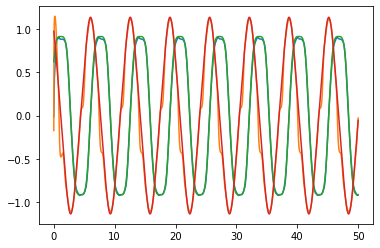

In [19]:
plotSimulation2D(tq_test, np.concatenate((x_hat,w_test[:,:2,0]),axis=1))

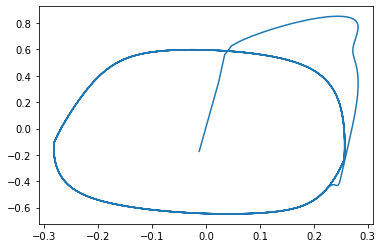

In [32]:
plotTrajectory2D(x_hat.T)

../lnos/observer/lueneberger.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.cat((torch.tensor(x_dot), z_dot))
../lnos/datasets/plot.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_fw[-1,dim_x:dim_x+dim_z,:],dtype=torch.float64)


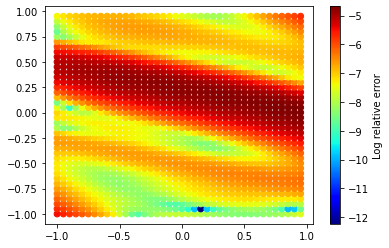

In [18]:
plotLogError2D(mesh, observer, T_star)